# Imports

In [ ]:
# Imports
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import lasso_path
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate


# Ignora todos los FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Funciones

In [2]:
def plot_scatter_variables(df, target, variables=None):
    if variables is None:
        variables = [col for col in df.columns if col != target]

    num_vars = len(variables)
    cols = 3  # Número de columnas en la cuadrícula de subplots
    rows = (num_vars // cols) + (num_vars % cols > 0)  # Ajustar número de filas
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Convertimos en un array 1D para indexar fácilmente

    for i, var in enumerate(variables):
        sns.scatterplot(x=df[var], y=df[target], ax=axes[i], alpha=0.6)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)
        axes[i].set_title(f'{var} vs {target}')
    
    # Ocultar ejes vacíos si sobran
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
   
    
def plot_correlation_heatmap(df, method=None):
    # Seleccionamos solo columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number])
    if method is None:
        corr_matrix = numeric_df.corr()
    else:
        corr_matrix = numeric_df.corr(method=method)
    # Dibujamos el heatmap
    plt.figure(figsize=(25,20))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, cbar=True)
    plt.title('Correlación entre las Variables Numéricas')
    plt.show()
  
    
def print_regression_report(y_true, y_pred):
    #evaluate our model's performance using mean squared error
    mse=mean_squared_error(y_true, y_pred)
    
    #evaluate our model's performance using mean absolute error
    mae=mean_absolute_error(y_true, y_pred)
    
    #evaluate our model's performance using r2_score
    R2_score=r2_score(y_true, y_pred)
    
    print("Mean Squared Error :",mse)
    print("mean Absolute Error :",mae)
    print("R2 Score :",R2_score)
    

def mdi_gbm(X, y):
    """
    Calcula y muestra la importancia de características usando MDI (Mean Decrease in Impurity)
    con GradientBoostingRegressor.
    """
    gbm = GradientBoostingRegressor(random_state=42)
    gbm.fit(X, y)
    mdi_importance = gbm.feature_importances_
    feature_names = X.columns
    indices = np.argsort(mdi_importance)[::-1]  # Ordenar de mayor a menor

    plt.figure(figsize=(15, 12))
    plt.bar(range(len(mdi_importance)), mdi_importance[indices], align="center", color='skyblue')
    plt.xticks(range(len(mdi_importance)), [feature_names[i] for i in indices], rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("MDI Importance")
    plt.title("Feature Importance (MDI) - Gradient Boosting Regressor")
    plt.tight_layout()
    plt.show()


def mda_gbm(X, y):
    """
    Calcula y muestra la importancia de características usando MDA (Mean Decrease Accuracy)
    mediante permutation importance con GradientBoostingRegressor.
    """
    feature_names = X.columns
    gbm = GradientBoostingRegressor(random_state=42)
    gbm.fit(X, y)
    
    perm_importance = permutation_importance(gbm, X, y, scoring="r2", n_repeats=10, random_state=42)
    importance_means = perm_importance.importances_mean
    importance_stds = perm_importance.importances_std
    indices = np.argsort(importance_means)[::-1]  # Ordenar de mayor a menor
    
    plt.figure(figsize=(15, 12))
    plt.bar(range(len(importance_means)), importance_means[indices], 
            yerr=importance_stds[indices], align="center", color="lightcoral", capsize=5)
    plt.xticks(range(len(importance_means)), [feature_names[i] for i in indices], rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("MDA Importance")
    plt.title("Feature Importance (MDA) - Gradient Boosting Regressor")
    plt.tight_layout()
    plt.show()

# Explicación de las variables


### MSSubClass: Identifies the type of dwelling involved in the sale.

| Code | Dwelling Type                                   | Tipo de Vivienda                         |
|------|-------------------------------------------------|------------------------------------------|
| 20   | 1-STORY 1946 & NEWER ALL STYLES                 | 1-PLANTA 1946 Y MÁS NUEVO, TODOS LOS ESTILOS |
| 30   | 1-STORY 1945 & OLDER                           | 1-PLANTA 1945 Y MÁS ANTIGUO              |
| 40   | 1-STORY W/FINISHED ATTIC ALL AGES              | 1-PLANTA CON ÁTICO TERMINADO, TODAS LAS EDADES |
| 45   | 1-1/2 STORY - UNFINISHED ALL AGES              | 1-1/2 PLANTA - SIN TERMINAR, TODAS LAS EDADES |
| 50   | 1-1/2 STORY FINISHED ALL AGES                  | 1-1/2 PLANTA TERMINADA, TODAS LAS EDADES |
| 60   | 2-STORY 1946 & NEWER                           | 2-PLANTAS 1946 Y MÁS NUEVO               |
| 70   | 2-STORY 1945 & OLDER                           | 2-PLANTAS 1945 Y MÁS ANTIGUO             |
| 75   | 2-1/2 STORY ALL AGES                           | 2-1/2 PLANTA, TODAS LAS EDADES           |
| 80   | SPLIT OR MULTI-LEVEL                           | NIVEL DIVIDIDO O MULTINIVEL              |
| 85   | SPLIT FOYER                                    | DIVISIÓN CON VESTÍBULO                   |
| 90   | DUPLEX - ALL STYLES AND AGES                   | DUPLEX - TODOS LOS ESTILOS Y EDADES      |
| 120  | 1-STORY PUD (Planned Unit Development) - 1946 & NEWER | 1-PLANTA PUD (Desarrollo de Unidad Planificada) - 1946 Y MÁS NUEVO |
| 150  | 1-1/2 STORY PUD - ALL AGES                     | 1-1/2 PLANTA PUD - TODAS LAS EDADES      |
| 160  | 2-STORY PUD - 1946 & NEWER                     | 2-PLANTAS PUD - 1946 Y MÁS NUEVO         |
| 180  | PUD - MULTILEVEL - INCL SPLIT LEV/FOYER        | PUD - MULTINIVEL - INCLUYE NIVEL DIVIDIDO/FOYER |
| 190  | 2 FAMILY CONVERSION - ALL STYLES AND AGES      | CONVERSIÓN A 2 FAMILIAS - TODOS LOS ESTILOS Y EDADES |

### MSZoning: Identifies the general zoning classification of the sale.

| Code | Zoning Type                                  | Tipo de Zonificación                      |
|------|----------------------------------------------|-------------------------------------------|
| A    | Agriculture                                  | Agricultura                               |
| C    | Commercial                                   | Comercial                                 |
| FV   | Floating Village Residential                 | Residencial en Isla Flotante              |
| I    | Industrial                                   | Industrial                                |
| RH   | Residential High Density                     | Residencial Alta Densidad                 |
| RL   | Residential Low Density                      | Residencial Baja Densidad                 |
| RP   | Residential Low Density Park                 | Residencial Parque de Baja Densidad       |
| RM   | Residential Medium Density                   | Residencial de Densidad Media             |

### LotFrontage: Linear feet of street connected to property

### LotArea: Lot size in square feet

### Street: Type of road access to property

| Code | Street Type  | Tipo de Calle |
|------|--------------|---------------|
| Grvl | Gravel       | Grava         |
| Pave | Paved        | Pavimentada   |

### Alley: Type of alley access to property

| Code | Alley Type   | Tipo de Acceso al Callejón |
|------|--------------|----------------------------|
| Grvl | Gravel       | Grava                      |
| Pave | Paved        | Pavimentado                |
| NA   | No alley access | Sin acceso al callejón   |

### LotShape: General shape of property

| Code | Shape Type    | Tipo de Forma |
|------|---------------|---------------|
| Reg  | Regular       | Regular       |
| IR1  | Slightly irregular | Ligeramente irregular |
| IR2  | Moderately Irregular | Moderadamente irregular |
| IR3  | Irregular     | Irregular     |

### LandContour: Flatness of the property

| Code | Contour Type  | Tipo de Contorno |
|------|---------------|------------------|
| Lvl  | Near Flat/Level | Nivelado       |
| Bnk  | Banked - Quick and significant rise from street grade to building | Bancada - Ascenso rápido y significativo |
| HLS  | Hillside - Significant slope from side to side | Ladera - Pendiente significativa de lado a lado |
| Low  | Depression    | Depresión       |

### Utilities: Type of utilities available

| Code  | Utility Type   | Tipo de Utilidad |
|-------|----------------|------------------|
| AllPub | All public Utilities (E,G,W,& S) | Todos los servicios públicos (electricidad, gas, agua y alcantarillado) |
| NoSewr | Electricity, Gas, and Water (Septic Tank) | Electricidad, gas y agua (tanque séptico) |
| NoSeWa | Electricity and Gas Only | Solo electricidad y gas |
| ELO    | Electricity only | Solo electricidad |

### LotConfig: Lot configuration

| Code    | Configuration Type | Tipo de Configuración |
|---------|--------------------|-----------------------|
| Inside  | Inside lot         | Lote interior         |
| Corner  | Corner lot         | Lote en esquina       |
| CulDSac | Cul-de-sac         | Callejón sin salida  |
| FR2     | Frontage on 2 sides of property | Frente a 2 lados de la propiedad |
| FR3     | Frontage on 3 sides of property | Frente a 3 lados de la propiedad |

### LandSlope: Slope of property

| Code | Slope Type      | Tipo de Pendiente |
|------|-----------------|-------------------|
| Gtl  | Gentle slope    | Pendiente suave   |
| Mod  | Moderate Slope  | Pendiente moderada|
| Sev  | Severe Slope    | Pendiente severa  |

### Neighborhood: Physical locations within Ames city limits

| Code    | Neighborhood Type  | Tipo de Vecindario    |
|---------|--------------------|-----------------------|
| Blmngtn | Bloomington Heights| Alturas de Bloomington|
| Blueste | Bluestem            | Bluestem              |
| BrDale  | Briardale           | Briardale             |
| BrkSide | Brookside           | Brookside             |
| ClearCr | Clear Creek        | Clear Creek           |
| CollgCr | College Creek      | College Creek         |
| Crawfor | Crawford           | Crawford              |
| Edwards | Edwards            | Edwards               |
| Gilbert | Gilbert            | Gilbert               |
| IDOTRR  | Iowa DOT and Rail Road | Iowa DOT y Ferrocarril |
| MeadowV | Meadow Village     | Villa Meadow          |
| Mitchel | Mitchell           | Mitchell              |
| Names   | North Ames         | Ames Norte            |
| NoRidge | Northridge         | Northridge            |
| NPkVill | Northpark Villa    | Villa Northpark       |
| NridgHt | Northridge Heights | Alturas Northridge    |
| NWAmes  | Northwest Ames     | Ames Noroeste         |
| OldTown | Old Town           | Ciudad Vieja          |
| SWISU   | South & West of Iowa State University | Sur y Oeste de la Universidad Estatal de Iowa |
| Sawyer  | Sawyer             | Sawyer                |
| SawyerW | Sawyer West        | Sawyer Oeste          |
| Somerst | Somerset           | Somerset              |
| StoneBr | Stone Brook        | Stone Brook           |
| Timber  | Timberland         | Tierra Forestal       |
| Veenker | Veenker            | Veenker               |

### Condition1: Proximity to various conditions

| Code   | Condition Type  | Tipo de Condición |
|--------|-----------------|-------------------|
| Artery | Adjacent to arterial street | Adyacente a calle principal |
| Feedr  | Adjacent to feeder street | Adyacente a calle secundaria |
| Norm   | Normal          | Normal            |
| RRNn   | Within 200' of North-South Railroad | A 200' de ferrocarril Norte-Sur |
| RRAn   | Adjacent to North-South Railroad | Adyacente al ferrocarril Norte-Sur |
| PosN   | Near positive off-site feature--park, greenbelt, etc. | Cerca de una característica positiva fuera del sitio (parque, zona verde, etc.) |
| PosA   | Adjacent to positive off-site feature | Adyacente a una característica positiva fuera del sitio |
| RRNe   | Within 200' of East-West Railroad | A 200' de ferrocarril Este-Oeste |
| RRAe   | Adjacent to East-West Railroad | Adyacente al ferrocarril Este-Oeste |

### Condition2: Proximity to various conditions (if more than one is present)

| Code   | Condition Type  | Tipo de Condición |
|--------|-----------------|-------------------|
| Artery | Adjacent to arterial street | Adyacente a calle principal |
| Feedr  | Adjacent to feeder street | Adyacente a calle secundaria |
| Norm   | Normal          | Normal            |
| RRNn   | Within 200' of North-South Railroad | A 200' de ferrocarril Norte-Sur |
| RRAn   | Adjacent to North-South Railroad | Adyacente al ferrocarril Norte-Sur |
| PosN   | Near positive off-site feature--park, greenbelt, etc. | Cerca de una característica positiva fuera del sitio (parque, zona verde, etc.) |
| PosA   | Adjacent to positive off-site feature | Adyacente a una característica positiva fuera del sitio |
| RRNe   | Within 200' of East-West Railroad | A 200' de ferrocarril Este-Oeste |
| RRAe   | Adjacent to East-West Railroad | Adyacente al ferrocarril Este-Oeste |



# Cargamos los datos

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

In [4]:
# Comprobamos que se hayan cargado correctamente los datos
print(train_df.head())
# print(test_df.head())
# print(sample_df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# Información inicial

## .head()


In [5]:
train_df.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
5         Lvl    AllPub  ...        0    NaN  MnPrv        Shed     700   
6         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
7         Lvl    AllPub  ...        0    NaN    NaN        Shed     350   
8         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
9         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  
5     10   2009        WD         Normal     143000  
6      8   2007        WD         Normal     307000  
7     11   2009        WD         Normal     200000  
8      4   2008        WD        Abnorml     129900  
9      1   2008        WD         Normal     118000  

[10 rows x 81 columns]

## .describre()

In [6]:
train_df.describe(include='all')
# train_df.describe()

Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1201.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    24.284752    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    59.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    69.000000    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    80.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       Alley LotShape LandContour Utilities  ...     PoolArea PoolQC  Fence  \
count     91     1460        1460      1460  ...  1460.000000      7    281   
unique     2        4           4         2  ...          NaN      3      4   
top     Grvl      Reg         Lvl    AllPub  ...          NaN     Gd  MnPrv   
freq      50      925        1311      1459  ...          NaN      3    157   
mean     NaN      NaN         NaN       NaN  ...     2.758904    NaN    NaN   
std      NaN      NaN         NaN       NaN  ...    40.177307    NaN    NaN   
min      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
25%      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
50%      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
75%      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
max      NaN      NaN         NaN       NaN  ...   738.000000    NaN    NaN   

       MiscFeature       MiscVal       MoSold       YrSold  SaleType  \
count           54   1460.000000  1460.000000  1460.000000      1460   
unique           4           NaN          NaN          NaN         9   
top           Shed           NaN          NaN          NaN        WD   
freq            49           NaN          NaN          NaN      1267   
mean           NaN     43.489041     6.321918  2007.815753       NaN   
std            NaN    496.123024     2.703626     1.328095       NaN   
min            NaN      0.000000     1.000000  2006.000000       NaN   
25%            NaN      0.000000     5.000000  2007.000000       NaN   
50%            NaN      0.000000     6.000000  2008.000000       NaN   
75%            NaN      0.000000     8.000000  2009.000000       NaN   
max            NaN  15500.000000    12.000000  2010.000000       NaN   

        SaleCondition      SalePrice  
count            1460    1460.000000  
unique              6            NaN  
top            Normal            NaN  
freq             1198            NaN  
mean              NaN  180921.195890  
std               NaN   79442.502883  
min               NaN   34900.000000  
25%               NaN  129975.000000  
50%               NaN  163000.000000  
75%               NaN  214000.000000  
max               NaN  755000.000000  

[11 rows x 81 columns]

## .info()

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Eliminamos columna id


In [8]:
# Eliminamos la columna 'Id'
train_df.drop('Id', axis=1, inplace=True)


# Preprocesamiento de datos - nulos


## Búsqueda con variables con valores faltantes.


In [9]:
missing_vars = []
for col in train_df.columns:
    n_missing = train_df[col].isnull().sum()
    if n_missing > 0:
        missing_vars.append(col)
        print(f"{col}: {n_missing} valores faltantes")

print("Variables con faltantes:", missing_vars)


LotFrontage: 259 valores faltantes
Alley: 1369 valores faltantes
MasVnrType: 872 valores faltantes
MasVnrArea: 8 valores faltantes
BsmtQual: 37 valores faltantes
BsmtCond: 37 valores faltantes
BsmtExposure: 38 valores faltantes
BsmtFinType1: 37 valores faltantes
BsmtFinType2: 38 valores faltantes
Electrical: 1 valores faltantes
FireplaceQu: 690 valores faltantes
GarageType: 81 valores faltantes
GarageYrBlt: 81 valores faltantes
GarageFinish: 81 valores faltantes
GarageQual: 81 valores faltantes
GarageCond: 81 valores faltantes
PoolQC: 1453 valores faltantes
Fence: 1179 valores faltantes
MiscFeature: 1406 valores faltantes
Variables con faltantes: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


## Tratamiento de los valores faltantes
- Variables numéricas con 0 o un valor negativo en caso de que el 0 esté dentro del dominio de valores.
- Variables categóricas con NA.

In [10]:
for col in missing_vars:
    if pd.api.types.is_numeric_dtype(train_df[col]):
        # Obtener los valores únicos no nulos
        unique_values = train_df[col].dropna().unique()
        # Si 0 está en el dominio, usamos -1; de lo contrario, 0
        if 0 in unique_values:
            train_df[col].fillna(-1, inplace=True)
        else:
            train_df[col].fillna(0, inplace=True)
    else:
        # Para variables categóricas, usamos 'NA'
        train_df[col].fillna("NA", inplace=True)

## Validación del tratamiento de valores faltantes.

In [11]:
missing_vars = []
for col in train_df.columns:
    n_missing = train_df[col].isnull().sum()
    if n_missing > 0:
        missing_vars.append(col)
        print(f"{col}: {n_missing} valores faltantes")

print("Variables con faltantes:", missing_vars)

Variables con faltantes: []


In [12]:
train_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave    NA      Reg   
1          20       RL         80.0     9600   Pave    NA      Reg   
2          60       RL         68.0    11250   Pave    NA      IR1   
3          70       RL         60.0     9550   Pave    NA      IR1   
4          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0     NA    NA          NA   
1         Lvl    AllPub       FR2  ...        0     NA    NA          NA   
2         Lvl    AllPub    Inside  ...        0     NA    NA          NA   
3         Lvl    AllPub    Corner  ...        0     NA    NA          NA   
4         Lvl    AllPub       FR2  ...        0     NA    NA          NA   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

# Histograma


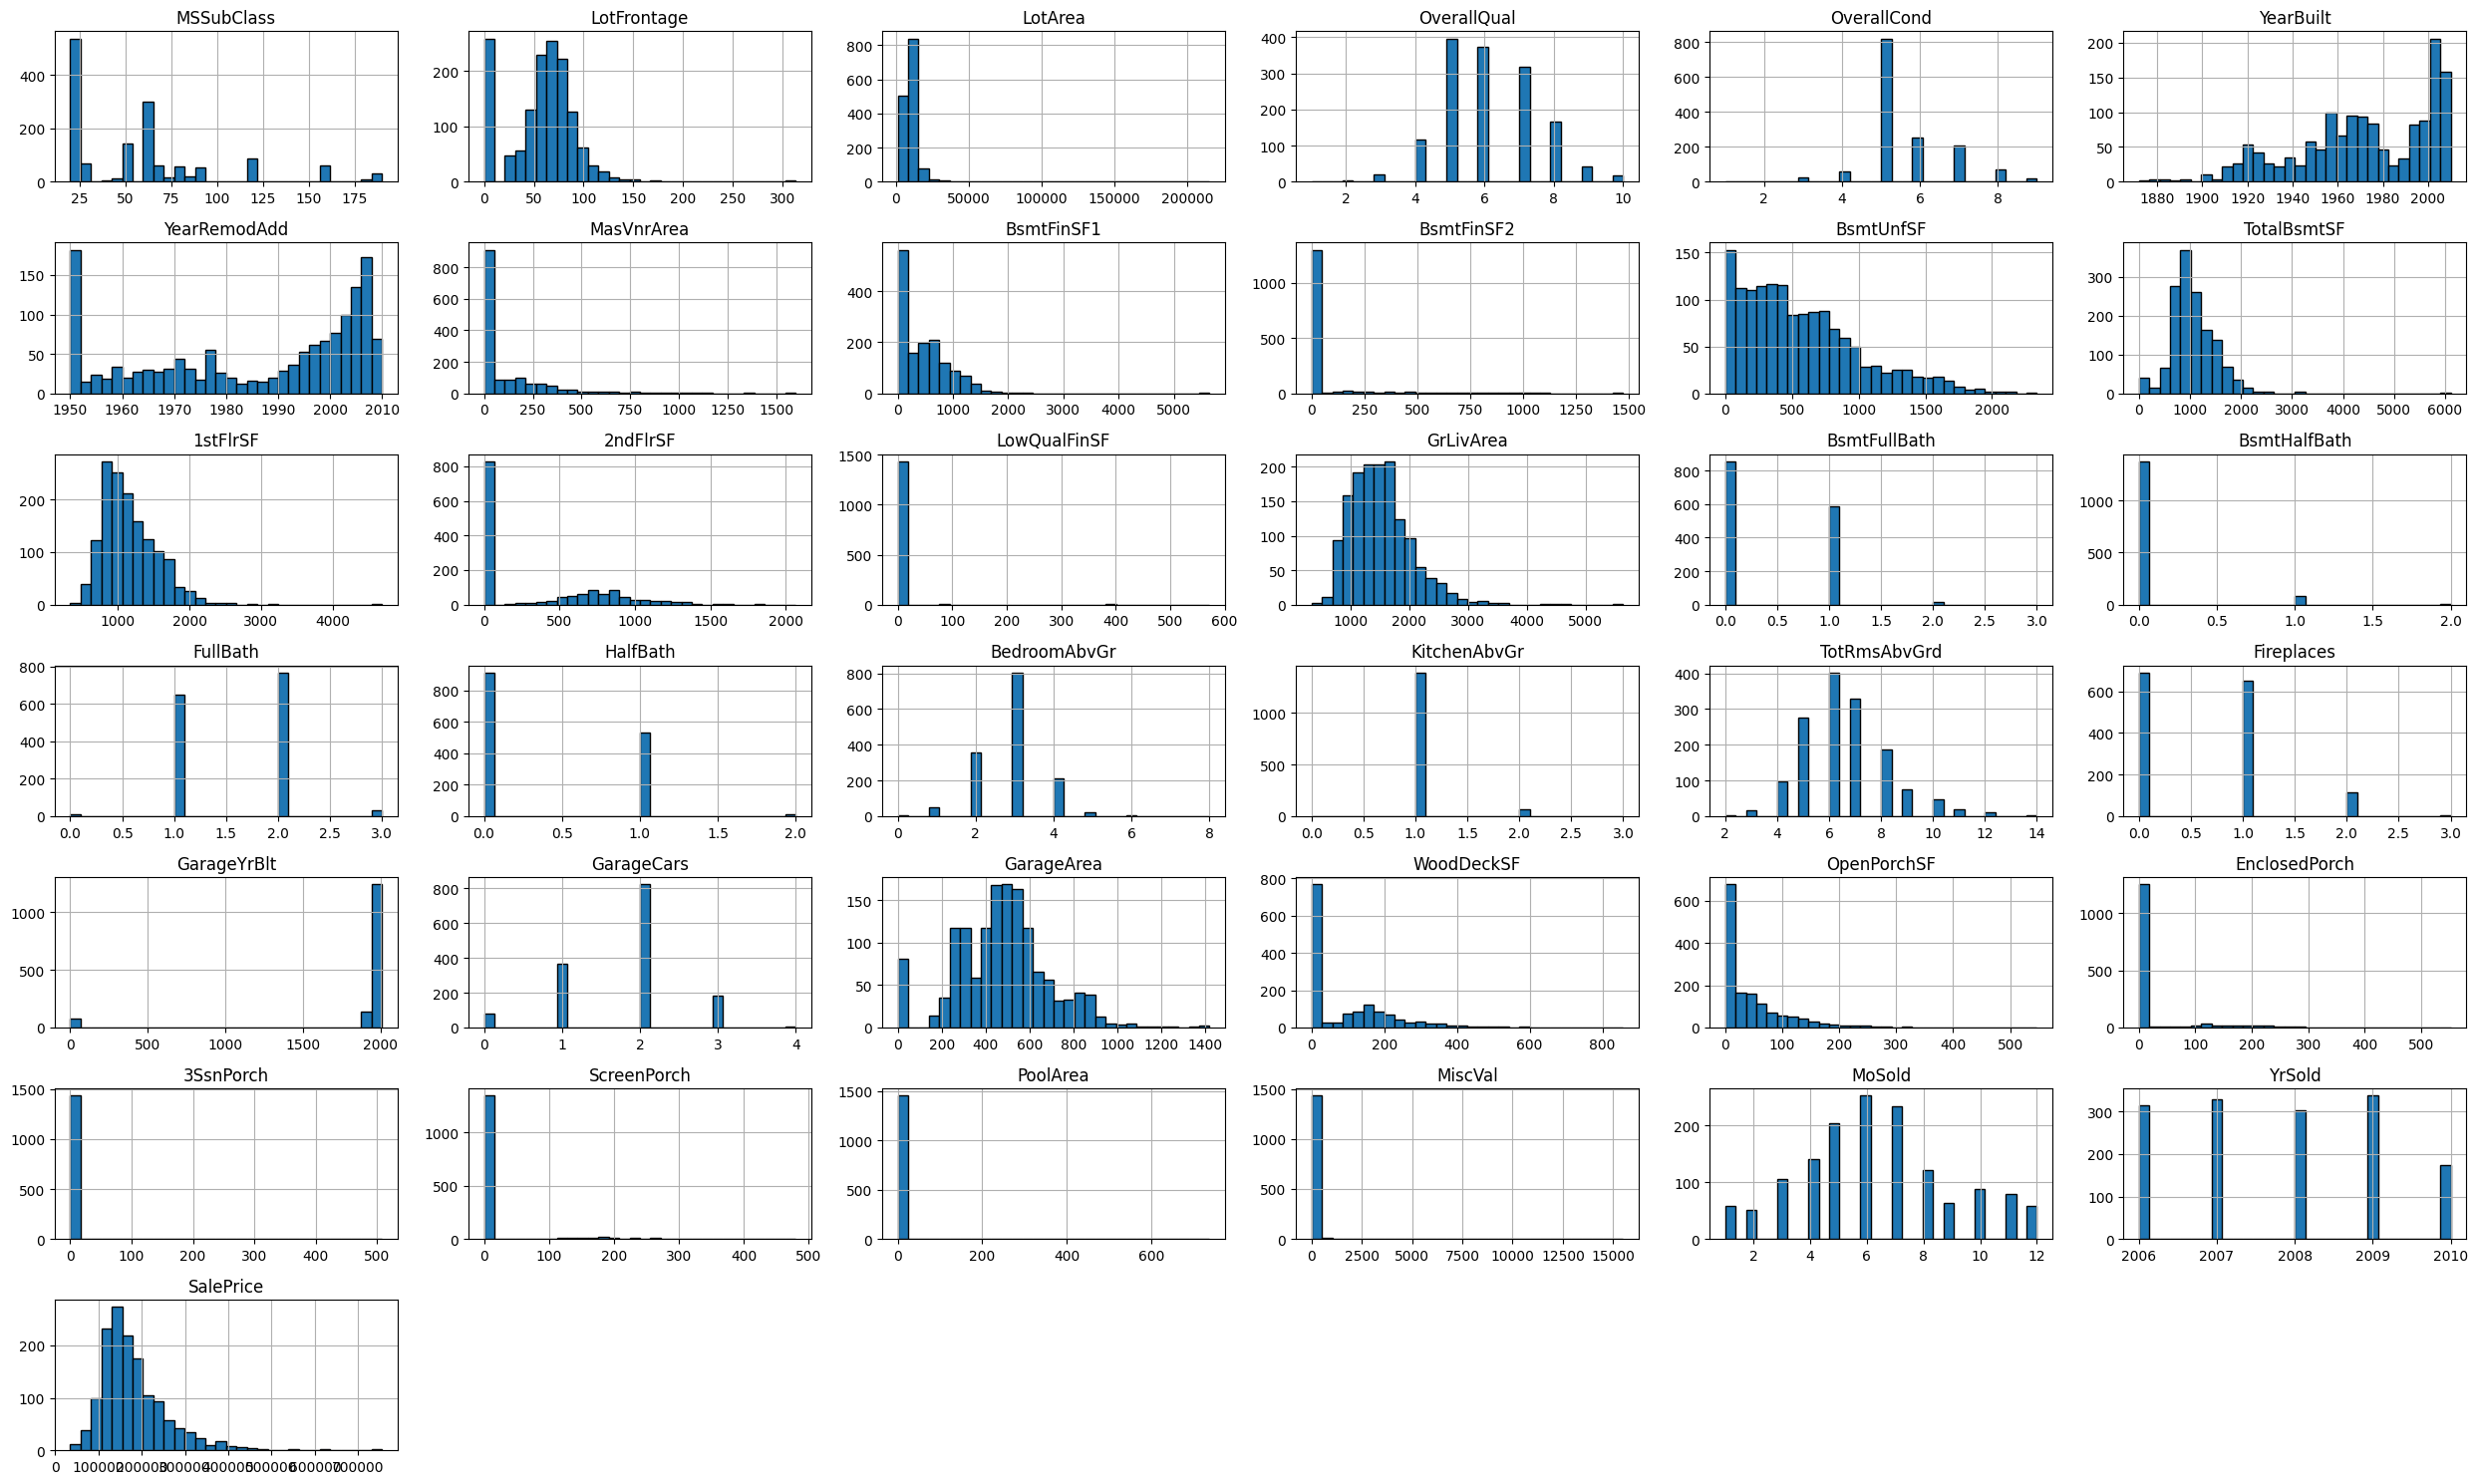

In [13]:
# Histograma
# Configuración del tamaño de las gráficas
train_df.hist(bins=30, figsize=(25, 15), edgecolor='black')
plt.tight_layout()
plt.show()

# Scatter

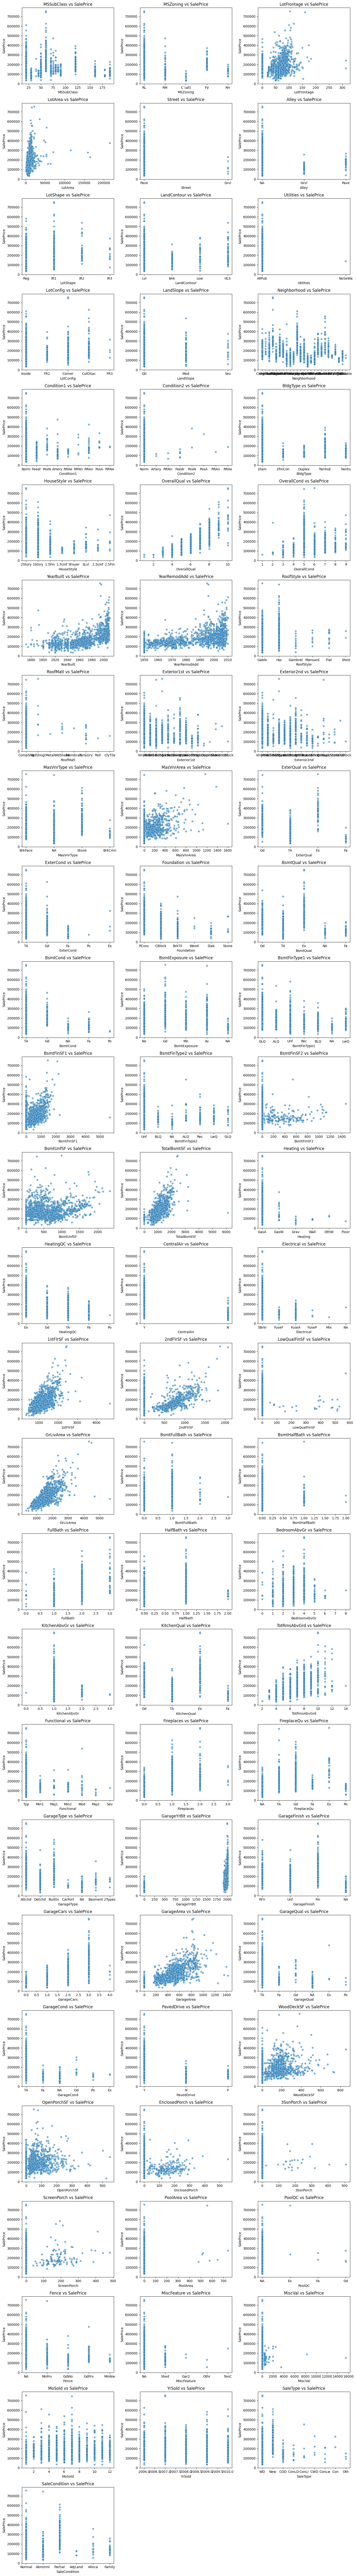

In [14]:
# Scatter
plot_scatter_variables(train_df, target='SalePrice')

# Correlaciones

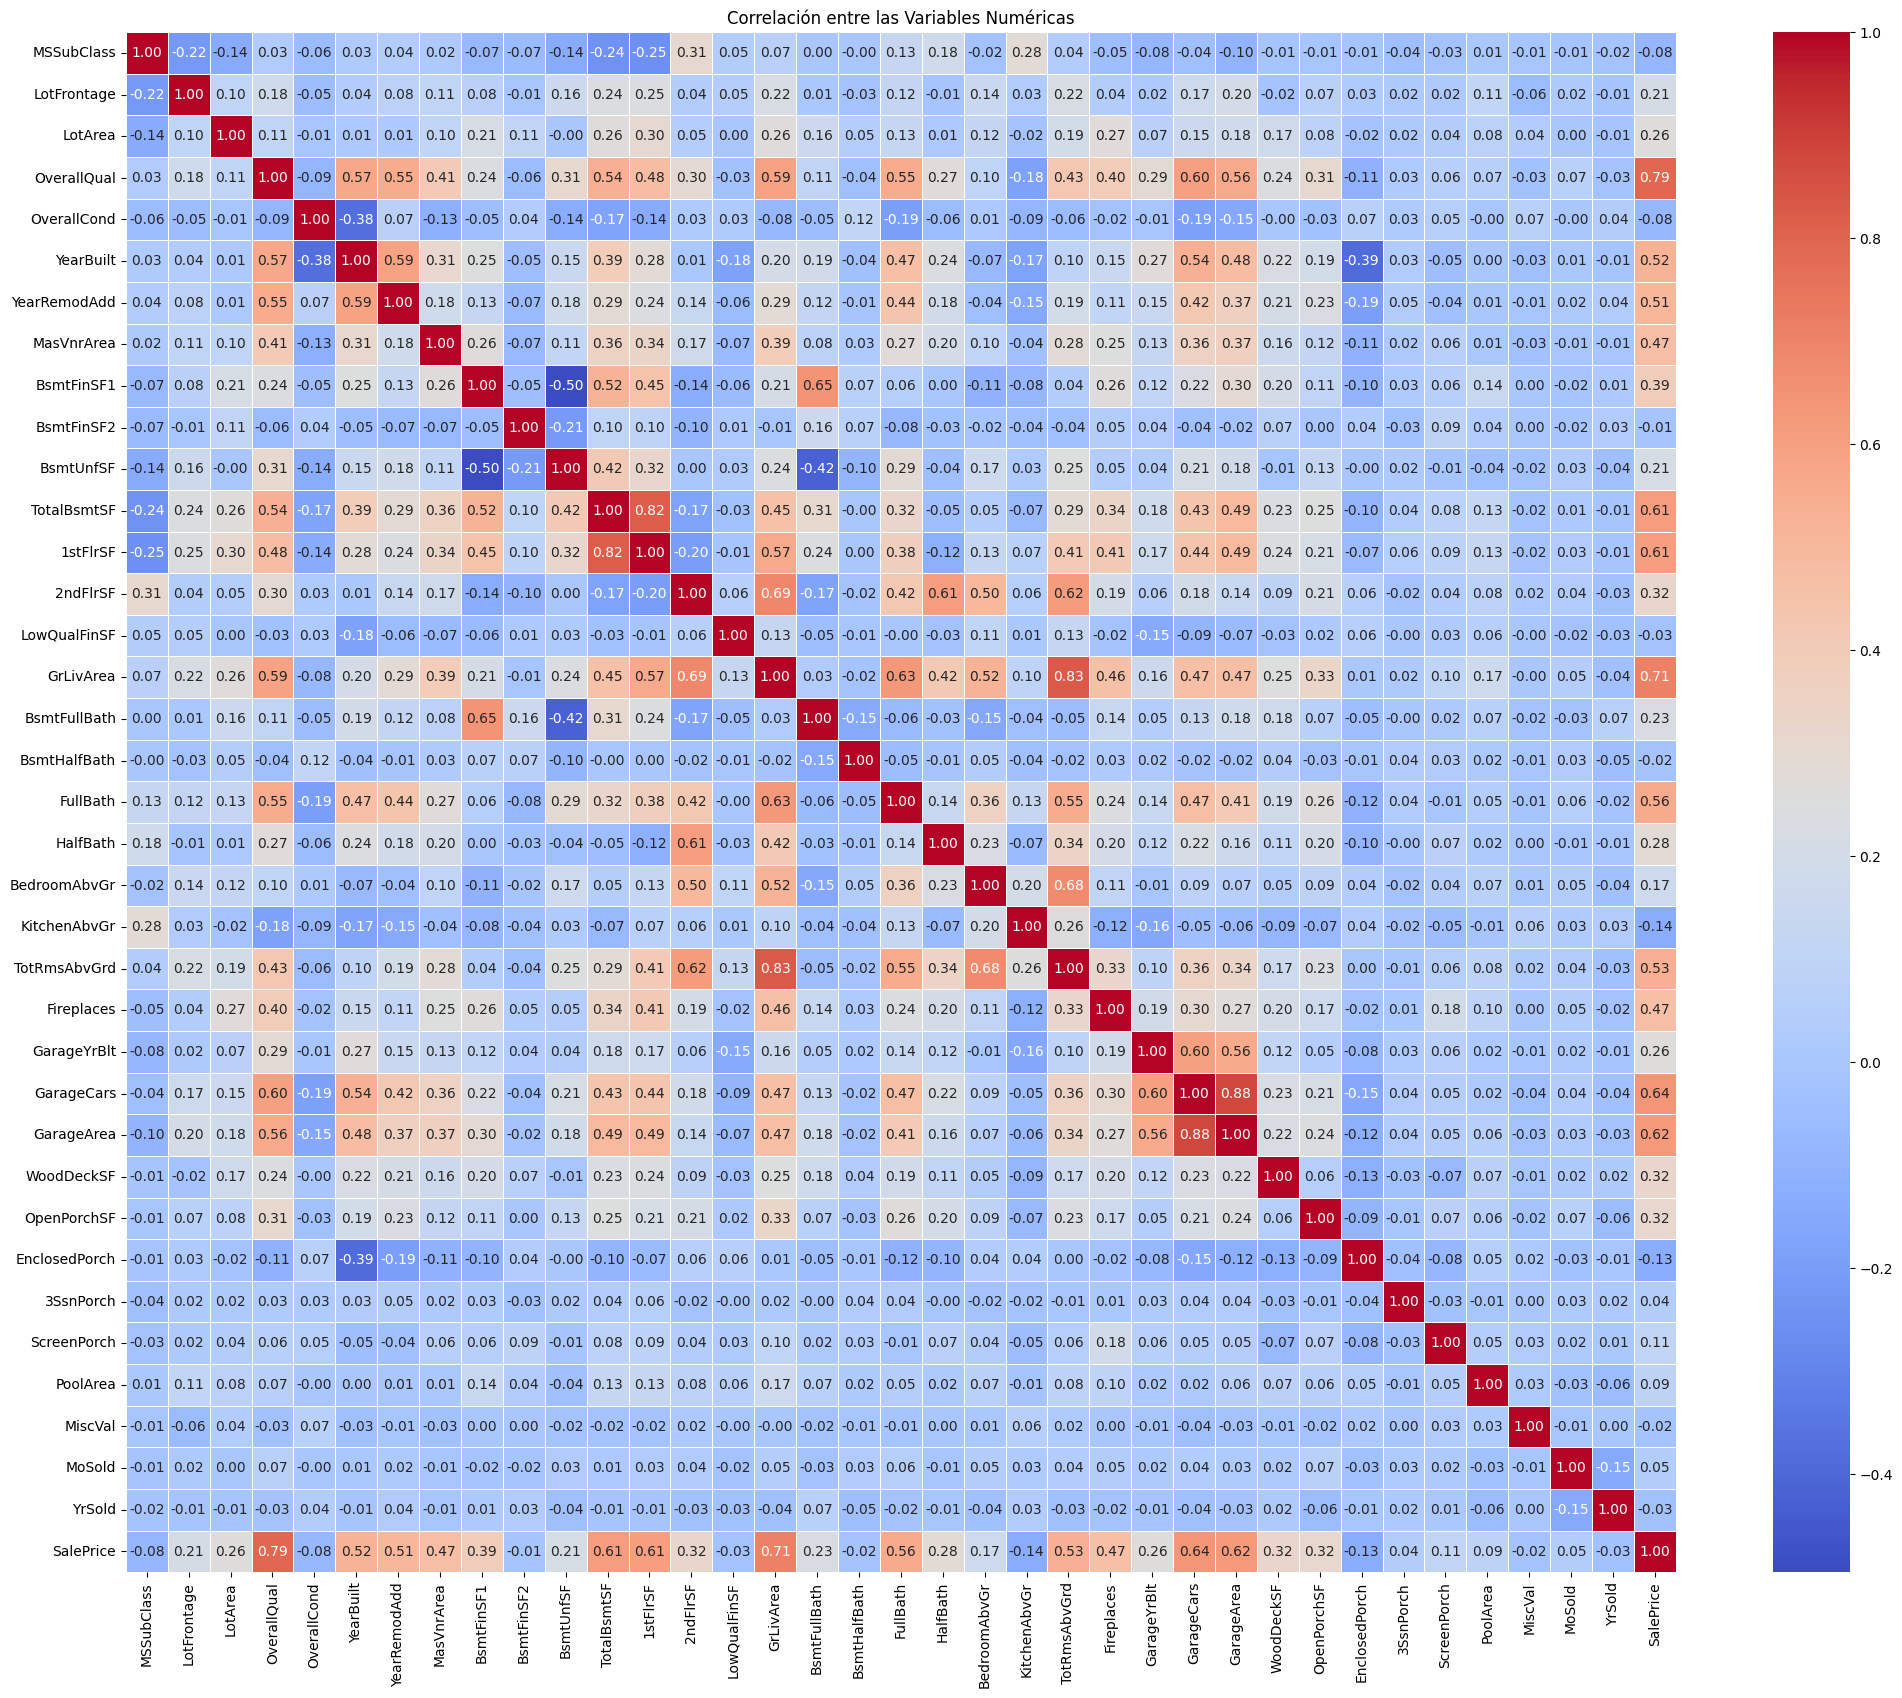

In [15]:
plot_correlation_heatmap(train_df, method='pearson')

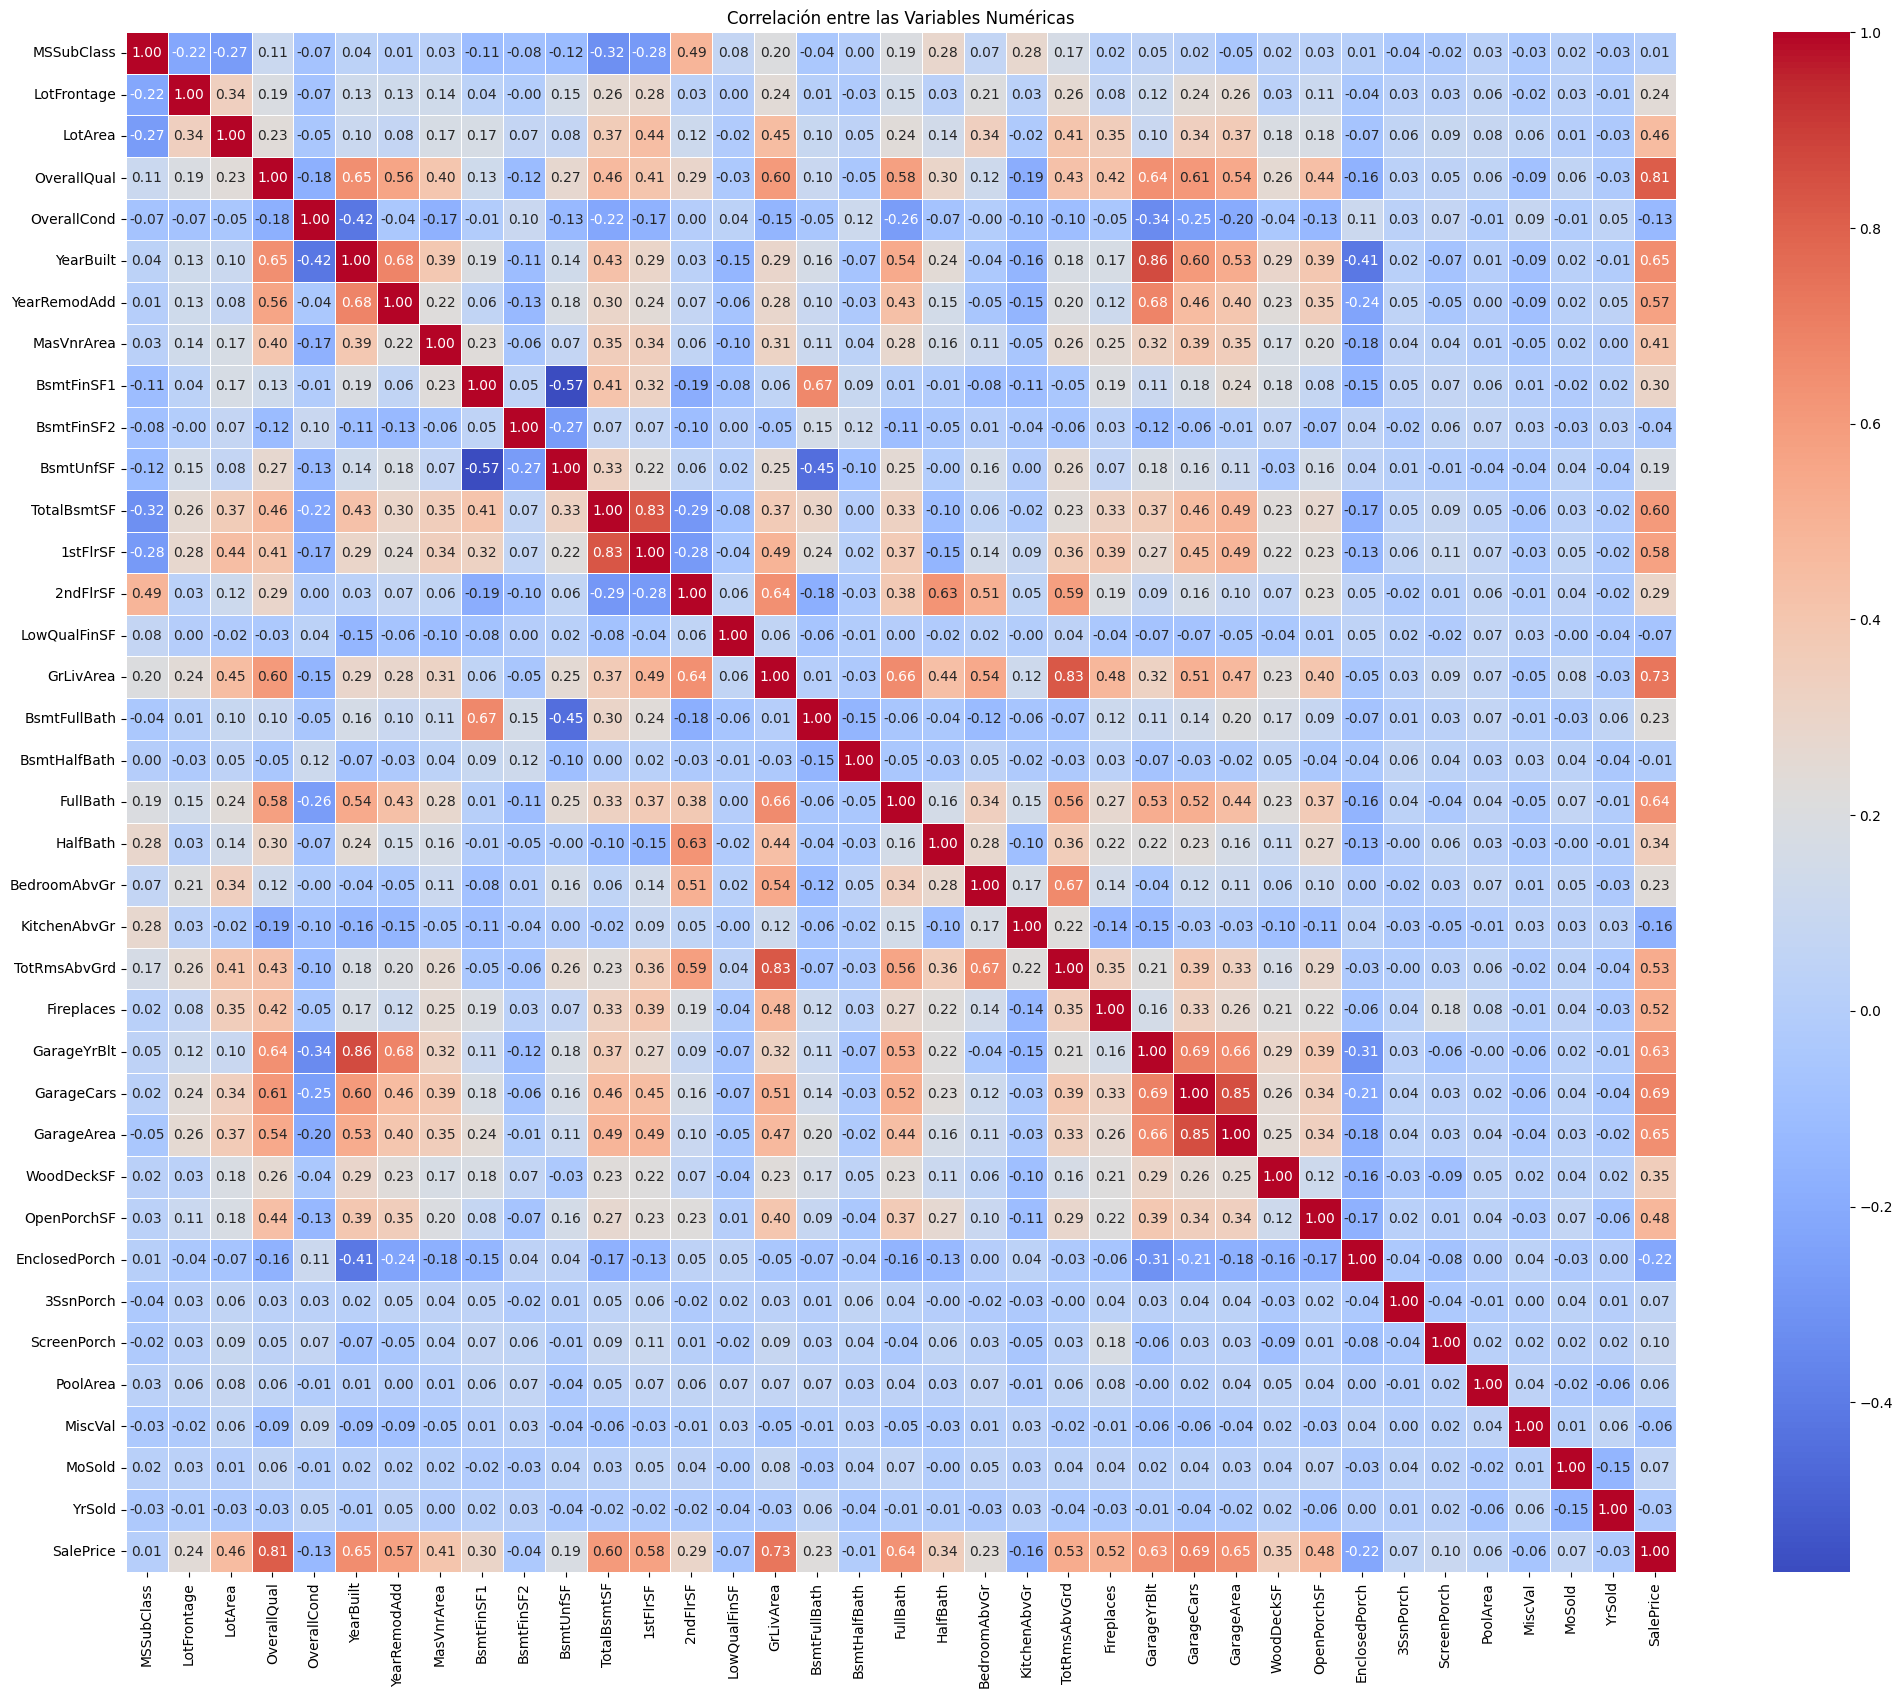

In [16]:
plot_correlation_heatmap(train_df, method='spearman')

# Notas


## 1. Histogramas de Variables Numéricas

- **Distribuciones sesgadas (skewed)**: Varias variables presentan una distribución asimétrica hacia la derecha (por ejemplo, `LotArea`, `SalePrice`, entre otras). Esto es común en datos de precios o superficies de propiedades, donde la mayoría de las casas tienen precios o tamaños “típicos” y hay pocas muy grandes o muy caras.
  
- **Posibles transformaciones**: Cuando las distribuciones están muy sesgadas, suele ser beneficioso aplicar transformaciones (como logaritmo) para normalizar los datos, lo cual puede mejorar el rendimiento de ciertos algoritmos de Machine Learning (especialmente los que asumen normalidad o se ven afectados por outliers).

- **Valores atípicos (outliers)**: En algunas variables, se observan colas muy largas o valores aislados muy grandes. Sería recomendable identificar concretamente cuáles son esos registros para decidir si se deben tratar (por ejemplo, recortar valores extremos, transformarlos o dejarlos según el objetivo del modelo).


## 2. Diagramas de Dispersión (Scatter Plots) vs. `SalePrice`

- **Relación con la calidad de la construcción (OverallQual)**: Se observa una tendencia clara a mayor calidad (`OverallQual`), mayor precio de venta (`SalePrice`). Este es uno de los factores más relevantes en la valoración de una vivienda.
  
- **Relación con el área habitable (GrLivArea, 1stFlrSF, TotalBsmtSF)**: Las variables que miden superficies habitables o totales también muestran una correlación positiva notable con el precio. Cuanta más superficie, mayor suele ser el valor de la vivienda.
  
- **Patrones lineales o no lineales**: Algunas variables muestran una relación aproximadamente lineal con `SalePrice` (por ejemplo, `GrLivArea`), mientras que otras pueden presentar relaciones más dispersas o con menor pendiente.
  
- **Outliers**: En algunas gráficas se aprecian puntos aislados (por ejemplo, casas con mucha área habitable pero un precio relativamente bajo o viceversa). Estos outliers pueden distorsionar el ajuste de ciertos modelos y conviene analizarlos individualmente.

## 3. Mapa de Calor de Correlaciones (Heatmap)

- **Variables con alta correlación con `SalePrice`**:  
  - `OverallQual` (calidad global de la casa)  
  - `GrLivArea` (superficie habitable sobre rasante)  
  - `GarageCars` y `GarageArea` (tamaño o capacidad del garaje)  
  - `TotalBsmtSF` (superficie total del sótano)  
  - `1stFlrSF` (superficie de la primera planta)  
  - `FullBath` (número de baños completos)  
  - `YearBuilt` y `YearRemodAdd` (año de construcción y de remodelación)  

  Estas variables probablemente tengan un gran peso a la hora de predecir el precio.

- **Colinealidad**: Se observa que ciertas variables están muy correlacionadas entre sí (por ejemplo, `GarageCars` y `GarageArea`, `TotalBsmtSF` y `BsmtFinSF1`, etc.). Esto puede generar problemas de multicolinealidad en modelos lineales o basados en coeficientes, aunque en modelos como GBM o árboles de decisión suele ser menos problemático. Aun así, conviene tenerlo en cuenta para no introducir redundancia excesiva

# Modelo  - BENCHMARK

## Usando sólo las variables numéricas


In [43]:
# Separamos la variable objetivo
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Seleccionamos solo las columnas numéricas
X_numeric = X.select_dtypes(include=['number'])

# Dividimos en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

# Entrenamos un modelo GBM básico
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# Realizamos predicciones
y_pred = gbm.predict(X_test)

# Evaluamos el rendimiento del modelo
print_regression_report(y_test, y_pred)

Mean Squared Error : 833372193.5646548
mean Absolute Error : 17586.218264824754
R2 Score : 0.891351140609407


In [44]:
# Predecimos en el conjunto de entrenamiento
y_train_pred = gbm.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

# Predecimos en el conjunto de test (validación)
y_test_pred = gbm.predict(X_test)
val_r2 = r2_score(y_test, y_test_pred)

print("R2 en entrenamiento:", train_r2)
print("R2 en validación:", val_r2)

R2 en entrenamiento: 0.963725117643595
R2 en validación: 0.891351140609407


## Usamos las 15 variables con mayor correlación (absoluta) - Pearson


In [34]:
corr_matrix = train_df.corr(numeric_only=True)
top_features = (corr_matrix['SalePrice']
                .abs()
                .sort_values(ascending=False)
                .head(15)
                .index)

# Quitamos 'SalePrice' de la lista de features
top_features_pearson = top_features.drop('SalePrice')

print("Variables seleccionadas:\n", top_features)


Variables seleccionadas:
 Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF'],
      dtype='object')


In [35]:
# Construimos el dataset con esas variables
X = train_df[top_features_pearson]
y = train_df['SalePrice']

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenamos un modelo GBM básico
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# Realizamos predicciones
y_pred = gbm.predict(X_test)

# Imprimimos las métricas
print_regression_report(y_test, y_pred)

Mean Squared Error : 819797020.5739964
mean Absolute Error : 18538.03719119196
R2 Score : 0.8931209705519638


In [36]:
for feature, importance in zip(X.columns, gbm.feature_importances_):
    print(f'{feature}: {importance:.4f}')

OverallQual: 0.5271
GrLivArea: 0.1737
GarageCars: 0.0546
GarageArea: 0.0085
TotalBsmtSF: 0.0513
1stFlrSF: 0.0253
FullBath: 0.0171
TotRmsAbvGrd: 0.0037
YearBuilt: 0.0371
YearRemodAdd: 0.0271
MasVnrArea: 0.0034
Fireplaces: 0.0162
BsmtFinSF1: 0.0502
WoodDeckSF: 0.0049


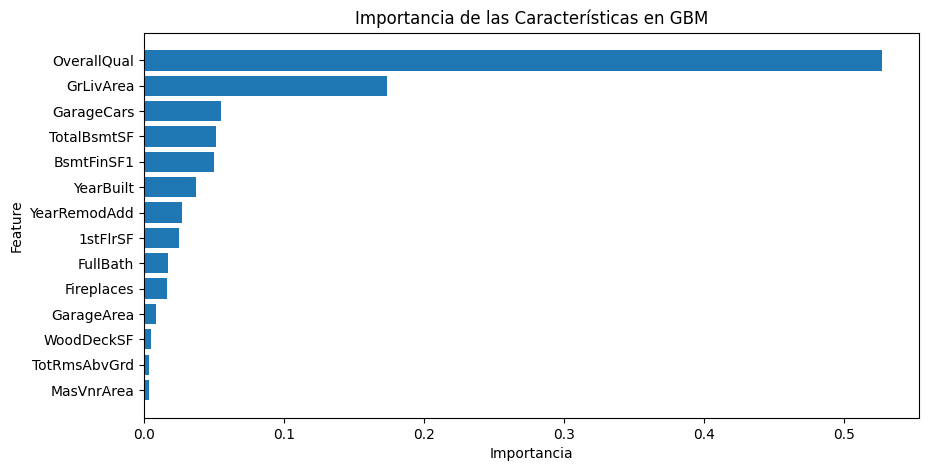

In [37]:
# Convertimos en un DataFrame para ordenarlas
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': gbm.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Graficamos
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de las Características en GBM")
plt.gca().invert_yaxis()  # Para que la más importante esté arriba
plt.show()


## Usamos las 15 variables con mayor correlación (absoluta) - Spearman - MEJOR RESULTADO EN ESTE PUNTO


In [38]:
# Calculamos la matriz de correlación usando Spearman
corr_matrix_spearman = train_df.corr(method='spearman', numeric_only=True)
top_features_spearman = (corr_matrix_spearman['SalePrice']
                         .abs()
                         .sort_values(ascending=False)
                         .head(15)
                         .index)

# Quitamos 'SalePrice' de la lista de features
top_features_spearman = top_features_spearman.drop('SalePrice')

print("Variables seleccionadas (Spearman):\n", top_features_spearman)

Variables seleccionadas (Spearman):
 Index(['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea',
       'FullBath', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd',
       'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea'],
      dtype='object')


In [39]:
# Construimos el dataset con esas variables
X = train_df[top_features_spearman]
y = train_df['SalePrice']

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenamos un modelo GBM básico
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# Realizamos predicciones
y_pred = gbm.predict(X_test)

# Imprimimos las métricas
print_regression_report(y_test, y_pred)

Mean Squared Error : 786507975.6290011
mean Absolute Error : 18959.225606508775
R2 Score : 0.8974609482850886


In [40]:
for feature, importance in zip(X.columns, gbm.feature_importances_):
    print(f'{feature}: {importance:.4f}')

OverallQual: 0.5298
GrLivArea: 0.1621
GarageCars: 0.0365
YearBuilt: 0.0347
GarageArea: 0.0134
FullBath: 0.0134
GarageYrBlt: 0.0072
TotalBsmtSF: 0.0738
1stFlrSF: 0.0367
YearRemodAdd: 0.0325
TotRmsAbvGrd: 0.0075
Fireplaces: 0.0179
OpenPorchSF: 0.0060
LotArea: 0.0286


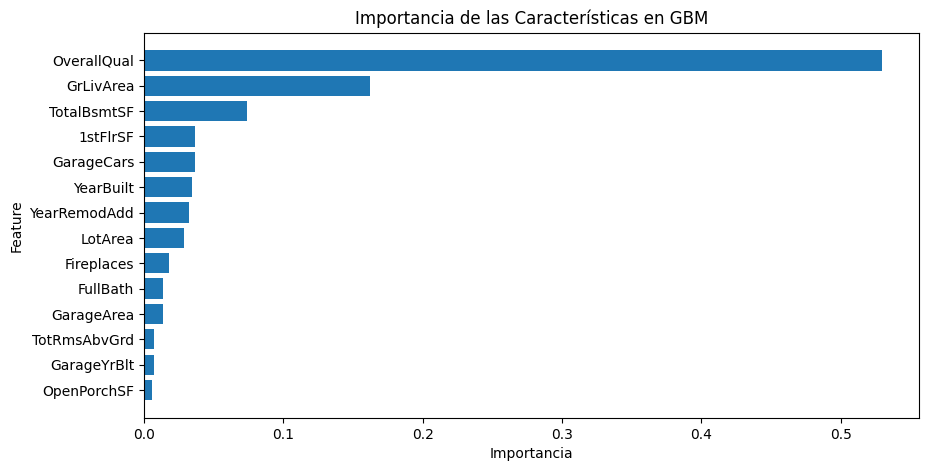

In [41]:
# Convertimos en un DataFrame para ordenarlas
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': gbm.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Graficamos
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de las Características en GBM")
plt.gca().invert_yaxis()  # Para que la más importante esté arriba
plt.show()


## Prueba de unión entre ambas listas de features


In [22]:
# Obtenemos la unión (valores únicos) de ambas listas
selected_features = sorted(list(set(top_features_pearson) | set(top_features_spearman)))
print("Variables seleccionadas (unión de ambos métodos):\n", selected_features)

Variables seleccionadas (unión de ambos métodos):
 ['1stFlrSF', 'BsmtFinSF1', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']


In [23]:
# Construimos el dataset con estas variables
X = train_df[selected_features]
y = train_df['SalePrice']

# Dividimos en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenamos un modelo GBM básico
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# Realizamos predicciones
y_pred = gbm.predict(X_test)

print_regression_report(y_test, y_pred)

Mean Squared Error : 803628450.4200659
mean Absolute Error : 18244.412717808456
R2 Score : 0.8952289083002672


# MDI - MDA - Feature importance

## Sobre todas las variable numéricas

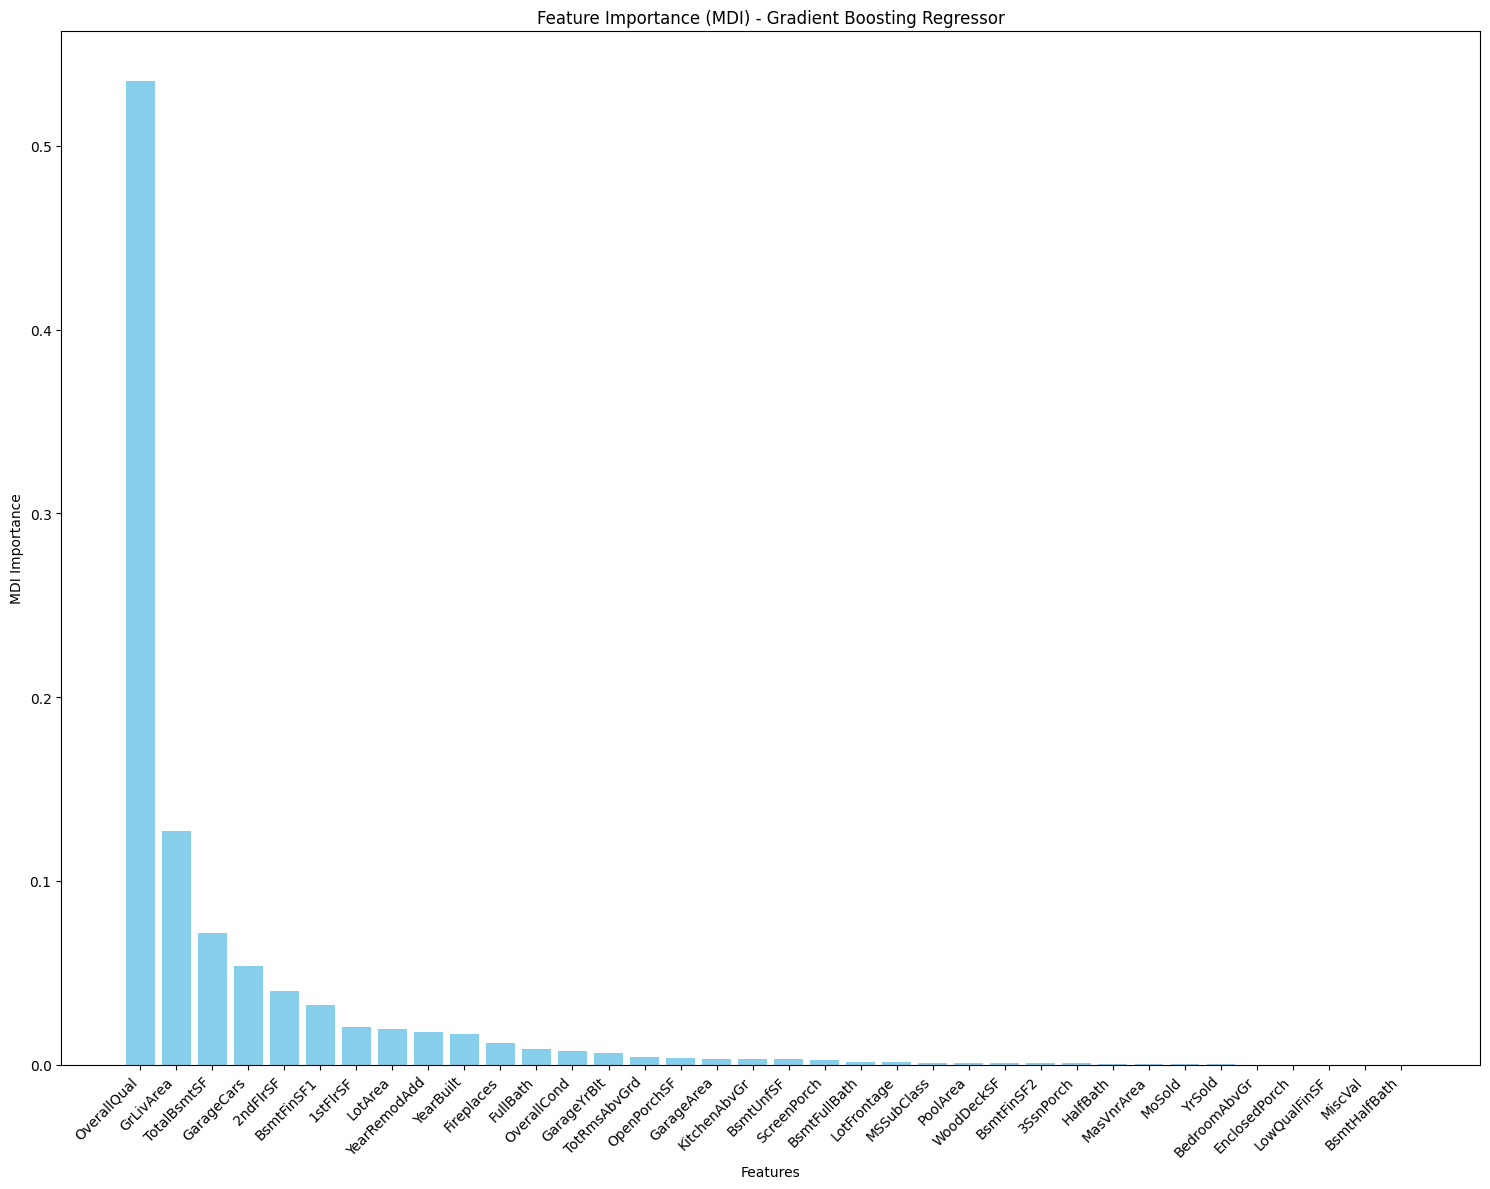

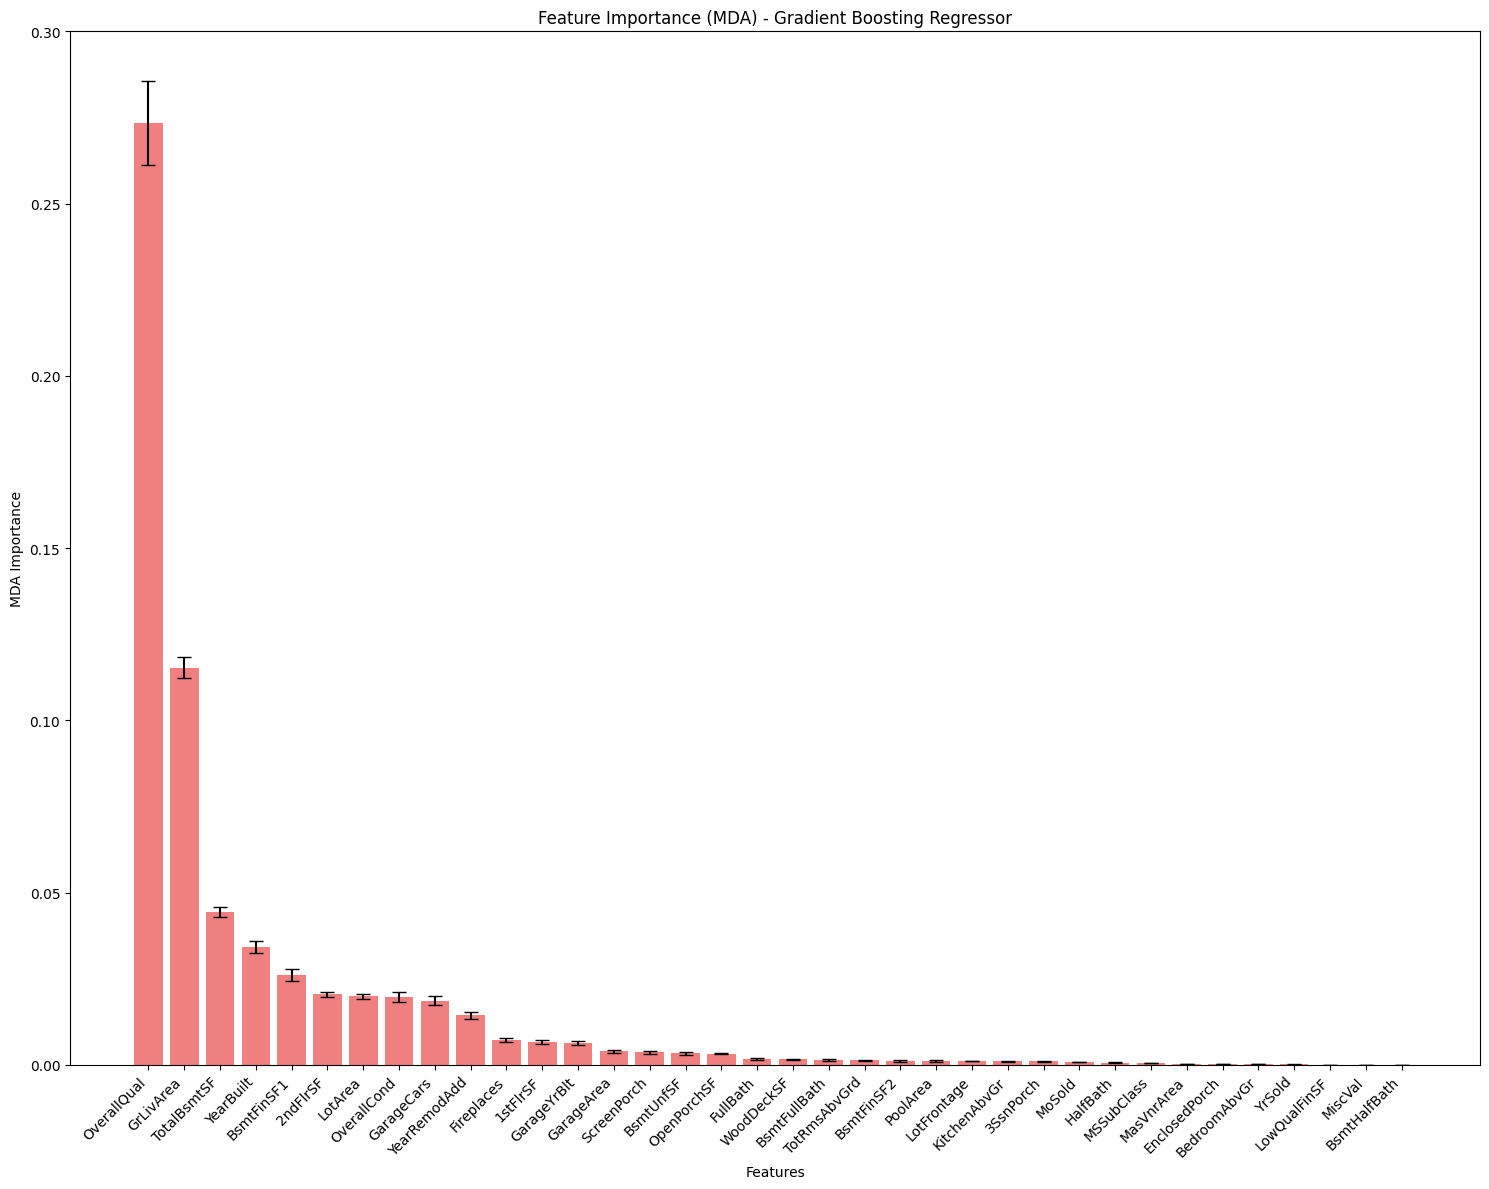

In [24]:
# Seleccionamos todas las variables numéricas excepto la variable objetivo
X_numeric = train_df.select_dtypes(include=[np.number]).drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Calculamos y visualizamos la importancia de características usando MDI y MDA
mdi_gbm(X_numeric, y)
mda_gbm(X_numeric, y)

## Modelo usando las top_features_spearman + variables destacadas mdi/mda faltantes


In [25]:
top_features_spearman_list = list(top_features_spearman)
additional_features = ['2ndFlrSF', 'OverallCond']

selected_features = top_features_spearman_list + additional_features
print("Variables seleccionadas:\n", selected_features)

Variables seleccionadas:
 ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea', 'FullBath', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', '2ndFlrSF', 'OverallCond']


In [26]:
# Construimos el dataset con estas variables
X = train_df[selected_features]
y = train_df['SalePrice']

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenamos un modelo GBM básico
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# Realizamos predicciones
y_pred = gbm.predict(X_test)

# Imprimimos las métricas
print_regression_report(y_test, y_pred)

Mean Squared Error : 775458376.4957025
mean Absolute Error : 18244.609114864452
R2 Score : 0.8989015127193554


# Benchmark Cross-Validation

In [27]:
# Construimos el dataset
X = train_df[selected_features]
y = train_df['SalePrice']

# Definimos el modelo
gbm = GradientBoostingRegressor(random_state=42)

# Definimos las métricas de evaluación a usar en CV
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error'
}

# Realizamos una validación cruzada con 5 folds
cv_results = cross_validate(gbm, X, y, cv=5, scoring=scoring)

# Calculamos las métricas promediadas
mean_r2 = np.mean(cv_results['test_r2'])
mean_rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
mean_mae = np.mean(-cv_results['test_neg_mean_absolute_error'])

print("Benchmark CV Results:")
print(f"R2 Score: {mean_r2:.4f}")
print(f"RMSE: {mean_rmse:.2f}")
print(f"MAE: {mean_mae:.2f}")

Benchmark CV Results:
R2 Score: 0.8699
RMSE: 28456.45
MAE: 17812.77


# GridSearchCV

- top_features_spearman + variables destacadas mdi/mda faltantes

In [28]:
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 
                     'YearBuilt', 'GarageArea', 'FullBath', 
                     'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 
                     'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 
                     'OpenPorchSF', 'LotArea', '2ndFlrSF', 
                     'OverallCond']

In [ ]:
# Construimos el dataset
X = train_df[selected_features]
y = train_df['SalePrice']

# Dividimos en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos el modelo base
gbm = GradientBoostingRegressor(random_state=42)

# Definimos un grid más amplio de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800],  # El número de árboles afecta directamente al sobreajuste
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.8, 1.0],                    # Usar subsample puede ayudar a reducir el sobreajuste
    'max_features': [None, 'sqrt', 'log2']       # Limitar el número de features a considerar en cada split
}

# Configuramos GridSearchCV con 5-fold CV y n_jobs=-1 para usar todos los núcleos disponibles
grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    cv=5,
    scoring='r2',  # Usamos R2 como scoring, pero recuerda complementar con otras métricas si es necesario
    n_jobs=-1,
    verbose=1
)

# Ejecutamos la búsqueda en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor puntuación (R2) durante la búsqueda:")
print(grid_search.best_score_)

# Evaluamos el modelo optimizado en el conjunto de test
best_gbm = grid_search.best_estimator_
y_pred = best_gbm.predict(X_test)

print("\nEvaluación en el conjunto de test:")
print_regression_report(y_test, y_pred)

In [ ]:
# Predecimos en el conjunto de entrenamiento
y_train_pred = best_gbm.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

# Predecimos en el conjunto de test (validación)
y_test_pred = best_gbm.predict(X_test)
val_r2 = r2_score(y_test, y_test_pred)

print("R2 en entrenamiento:", train_r2)
print("R2 en validación:", val_r2)


R2 en entrenamiento: 0.9872203143560995
R2 en validación: 0.9085536158242857


### GridSearchCV con cambios

In [ ]:
# Construimos el dataset
X = train_df[selected_features]
y = train_df['SalePrice']

# Dividimos en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos el modelo base
gbm = GradientBoostingRegressor(random_state=42)

# Definimos un grid más amplio de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5],              # Eliminamos 10 para reducir combinaciones
    'subsample': [0.7, 0.8, 1.0],
    'max_features': ['sqrt', 'log2'],
    'loss': ['squared_error', 'huber'],      # Probar distintas funciones de pérdida
    'max_leaf_nodes': [None, 10, 20],        # Limitar el tamaño de los árboles
    
}

# Configuramos GridSearchCV con 5-fold CV y n_jobs=-1 para usar todos los núcleos disponibles
grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Ejecutamos la búsqueda en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor puntuación (R2) durante la búsqueda:")
print(grid_search.best_score_)

# Evaluamos el modelo optimizado en el conjunto de test
best_gbm = grid_search.best_estimator_
y_pred = best_gbm.predict(X_test)

print("\nEvaluación en el conjunto de test:")
print_regression_report(y_test, y_pred)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}

Mejor puntuación (R2) durante la búsqueda:
0.8606833226824353

Evaluación en el conjunto de test:
Mean Squared Error : 692904982.0829803
mean Absolute Error : 17548.811783027893
R2 Score : 0.909664209400413


In [ ]:
# Predecimos en el conjunto de entrenamiento
y_train_pred = best_gbm.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

# Predecimos en el conjunto de test (validación)
y_test_pred = best_gbm.predict(X_test)
val_r2 = r2_score(y_test, y_test_pred)

print("R2 en entrenamiento:", train_r2)
print("R2 en validación:", val_r2)


R2 en entrenamiento: 0.9710450223379995
R2 en validación: 0.909664209400413


---

# Integración de variables categóricas


In [ ]:
numeric_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea',
    'FullBath', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd',
    'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', '2ndFlrSF', 'OverallCond'
]


# Variables categóricas que se van a codificar
cat_ordinal = ['ExterQual', 'KitchenQual', 'BsmtQual']
cat_nominal = ['Neighborhood', 'HouseStyle', 'SaleCondition']

df = train_df.copy()

In [ ]:
# CODIFICACIÓN DE VARIABLES ORDINALES
qual_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0}

for col in cat_ordinal:
    if col in df.columns:
        df[col] = df[col].map(qual_map).fillna(0)  # Si hubiera nulos

# CODIFICACIÓN ONE-HOT (VARIABLES NOMINALES)
# Seleccionamos solo las columnas presentes
cat_nominal_existing = [c for c in cat_nominal if c in df.columns]
df_encoded_nominal = pd.get_dummies(df[cat_nominal_existing], drop_first=True)

Calculando MDI con variables numéricas + categóricas codificadas...


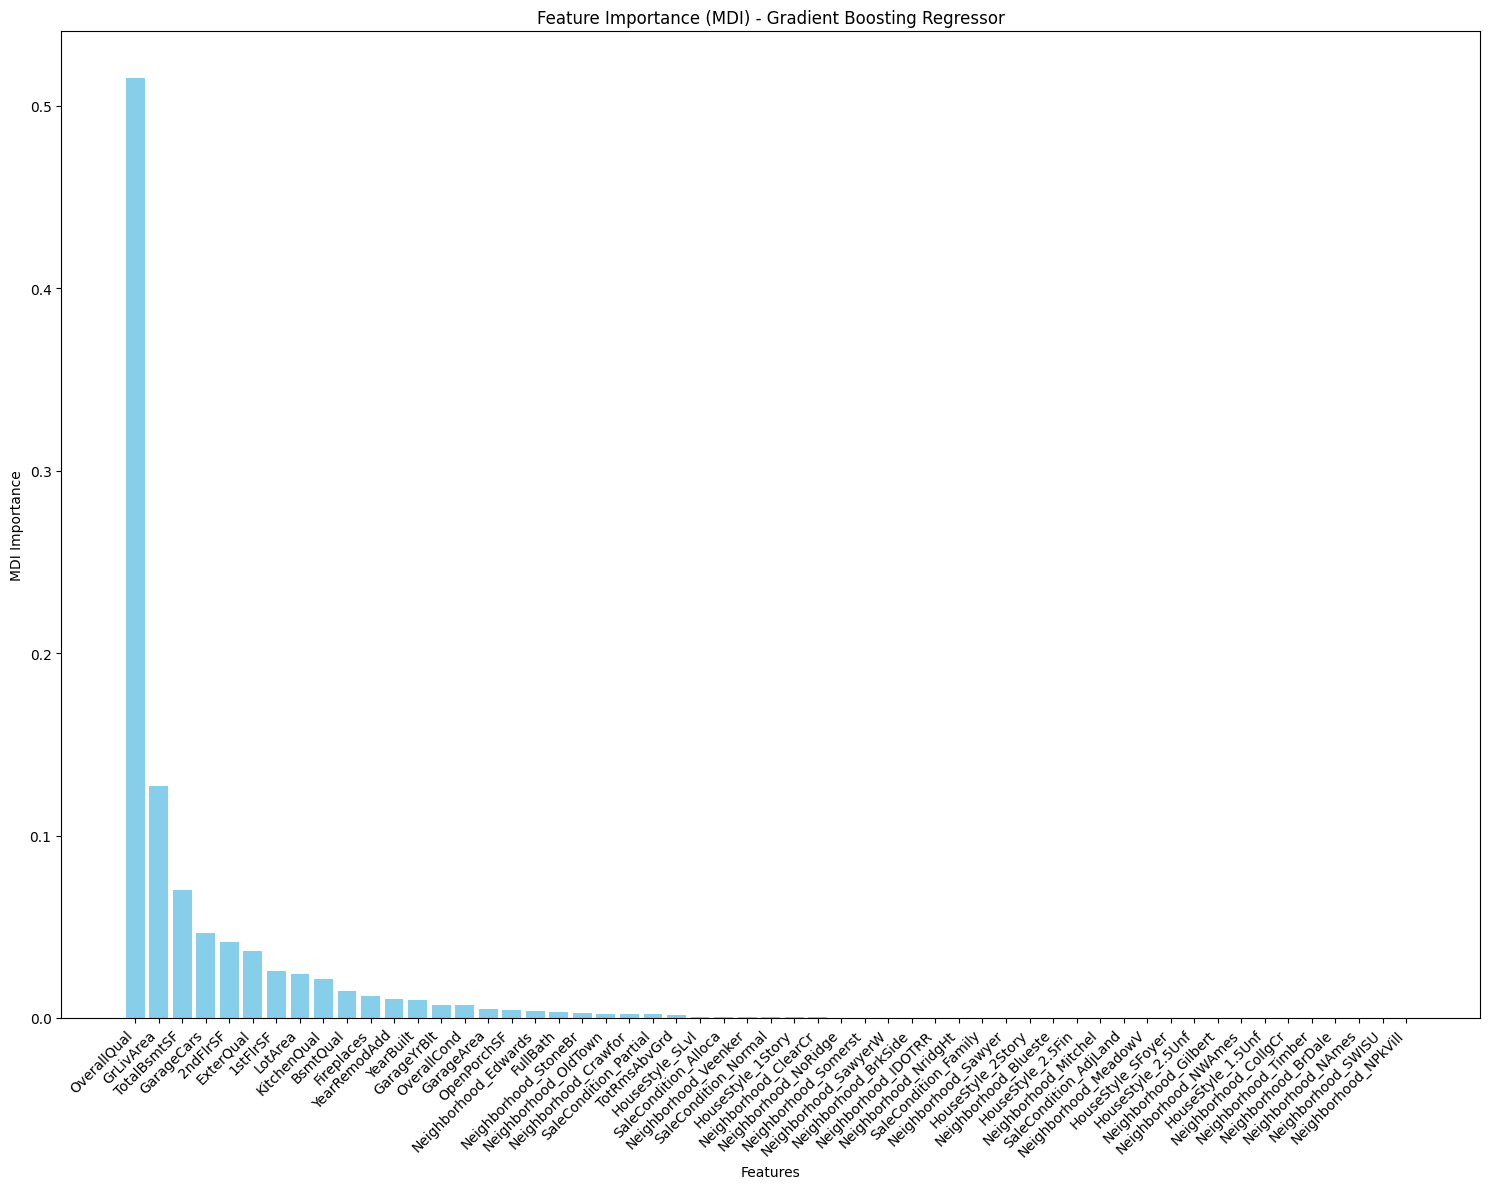

Calculando MDA con variables numéricas + categóricas codificadas...


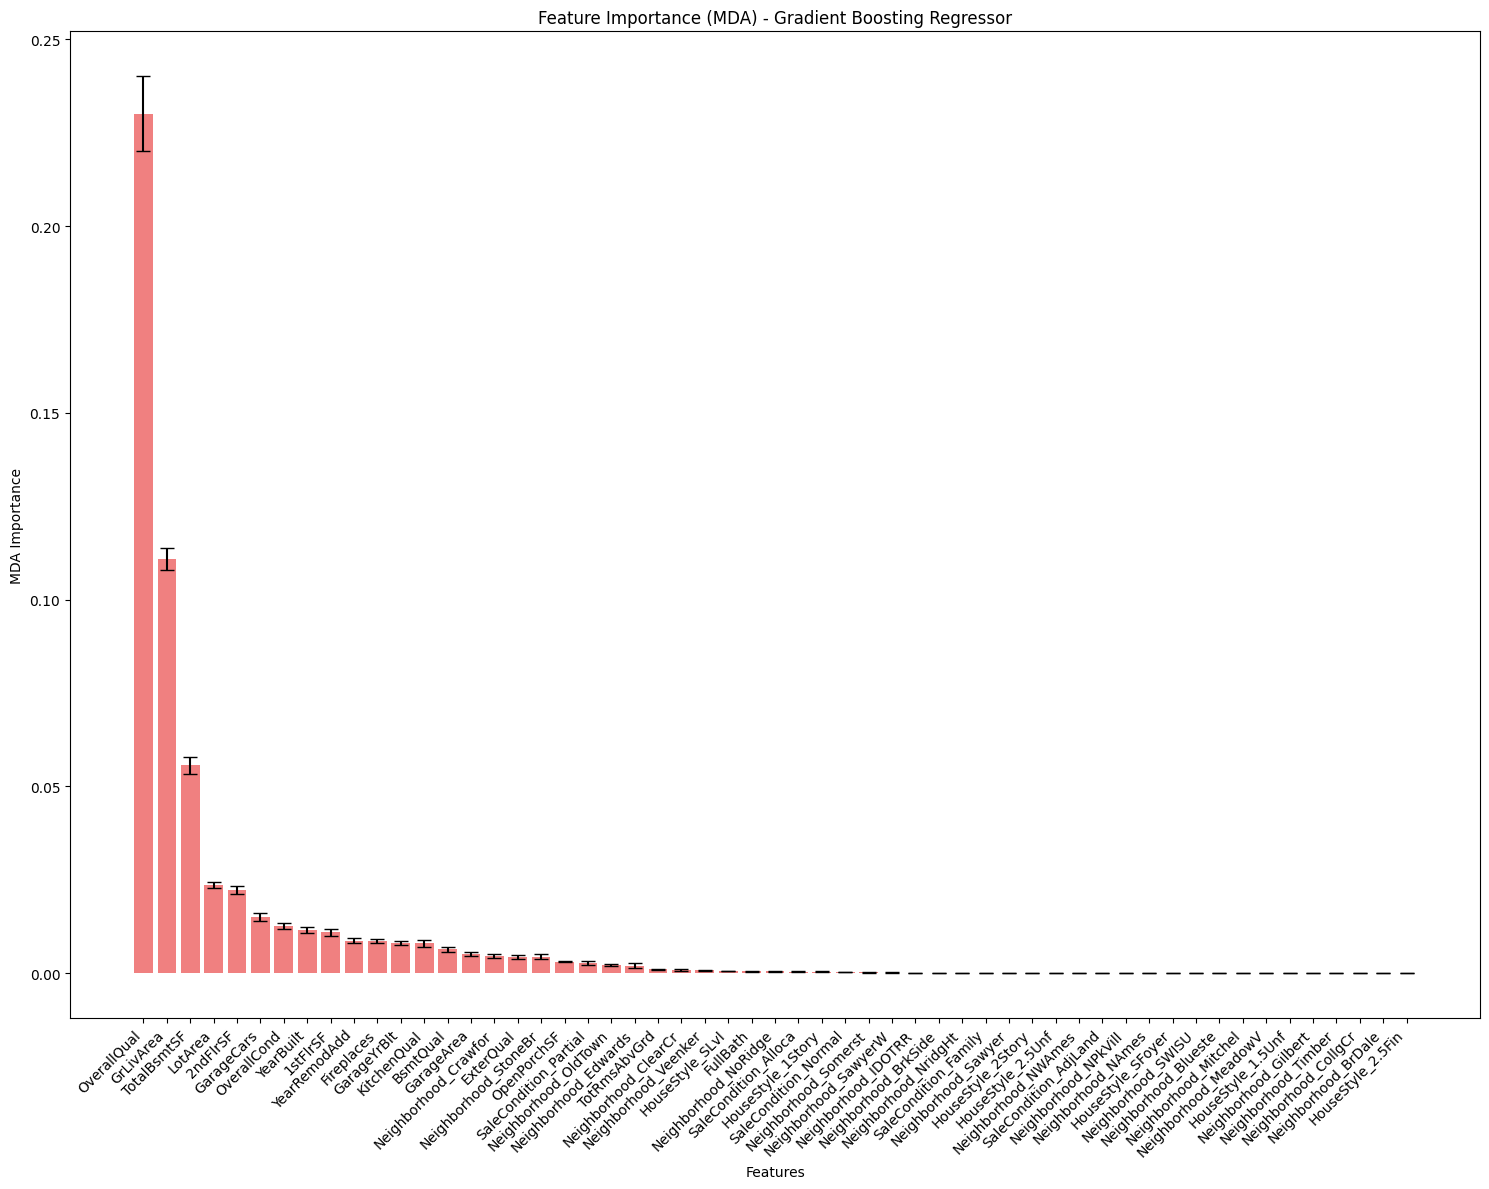

In [ ]:
X_num = df[numeric_features + cat_ordinal].copy()

# Concatenamos con las codificadas nominales
X_final = pd.concat([X_num, df_encoded_nominal], axis=1)

# Variable objetivo
y = df['SalePrice']

# ===== 6) CALCULAMOS MDI Y MDA =====
print("Calculando MDI con variables numéricas + categóricas codificadas...")
mdi_gbm(X_final, y)

print("Calculando MDA con variables numéricas + categóricas codificadas...")
mda_gbm(X_final, y)

## Modelo con nuevas características

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# =====================================
# 7) Evaluación del Modelo
# =====================================
y_pred = gbm.predict(X_test)
print("Resultados del modelo con variables categóricas añadidas:")
print_regression_report(y_test, y_pred)

Resultados del modelo con variables categóricas añadidas:
Mean Squared Error : 743856210.6277772
mean Absolute Error : 17067.488667382757
R2 Score : 0.9030215677227937


In [ ]:
# # Construimos el dataset
# X = train_df[selected_features]
# y = train_df['SalePrice']

# # Dividimos en conjuntos de entrenamiento y test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos el modelo base
gbm = GradientBoostingRegressor(random_state=42)

# Definimos un grid más amplio de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5],              # Eliminamos 10 para reducir combinaciones
    'subsample': [0.7, 0.8, 1.0],
    'max_features': ['sqrt', 'log2'],
    'loss': ['squared_error', 'huber'],      # Probar distintas funciones de pérdida
    'max_leaf_nodes': [None, 10, 20],        # Limitar el tamaño de los árboles
    
}

# Configuramos GridSearchCV con 5-fold CV y n_jobs=-1 para usar todos los núcleos disponibles
grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Ejecutamos la búsqueda en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor puntuación (R2) durante la búsqueda:")
print(grid_search.best_score_)

# Evaluamos el modelo optimizado en el conjunto de test
best_gbm = grid_search.best_estimator_
y_pred = best_gbm.predict(X_test)

print("\nEvaluación en el conjunto de test:")
print_regression_report(y_test, y_pred)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}

Mejor puntuación (R2) durante la búsqueda:
0.8743868116313713

Evaluación en el conjunto de test:
Mean Squared Error : 766338772.4279052
mean Absolute Error : 16799.317637397606
R2 Score : 0.900090458772165


In [ ]:
# Predecimos en el conjunto de entrenamiento
y_train_pred = best_gbm.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

# Predecimos en el conjunto de test (validación)
y_test_pred = best_gbm.predict(X_test)
val_r2 = r2_score(y_test, y_test_pred)

print("R2 en entrenamiento:", train_r2)
print("R2 en validación:", val_r2)


R2 en entrenamiento: 0.9783136231917212
R2 en validación: 0.900090458772165


In [ ]:
cat_vars = ['Neighborhood', 'HouseStyle', 'SaleCondition', 'ExterQual', 'KitchenQual', 'BsmtQual']

for cat in cat_vars:
    print(f"\n--- Distribución de la variable '{cat}' ---")
    print(train_df[cat].value_counts(dropna=False))


--- Distribución de la variable 'Neighborhood' ---
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

--- Distribución de la variable 'HouseStyle' ---
HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64

--- Distribución de la variable 'SaleCondition' ---
SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64

--- Distribución de la variable 'ExterQual' ---
ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64

--- Distribución de 